In [8]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_curve,auc, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

df = pd.read_csv('magic04.data',
        header=None)
df = df.sample(frac=1)
#x = df.iloc[:,0:9].values
#y = df.iloc[:,10].values
x = df.iloc[:500,0:9].values
y = df.iloc[:500,10].values

le = LabelEncoder()
y = le.fit_transform(y)
df.columns = ['Length' , 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'Class']

x_train , x_test , y_train , y_test = train_test_split(x,
                                        y, 
                                        test_size=0.2, 
                                        stratify=y, 
                                        random_state=1)

F1=make_scorer(f1_score)
recall=make_scorer(recall_score)
accuracy=make_scorer(accuracy_score)

# RandomForestClassifier

In [9]:
n_estimators = [10 , 50 , 100, 500]
max_depth=[10,100,200]
pipe_forest = make_pipeline(RandomForestClassifier(random_state=1))
param_grid_forest = [{'randomforestclassifier__n_estimators': n_estimators, 'randomforestclassifier__max_depth':max_depth, 'randomforestclassifier__criterion': ['gini']},
                        {'randomforestclassifier__n_estimators': n_estimators, 'randomforestclassifier__max_depth':max_depth, 'randomforestclassifier__criterion': ['entropy']}]

In [10]:
gs_forest_f1 = GridSearchCV(estimator=pipe_forest,
                        param_grid=param_grid_forest,
                        scoring=F1,
                        n_jobs=-1,
                        refit=True,
                        cv=10,
                        verbose=10)
gs_forest_f1=gs_forest_f1.fit(x_train, y_train)
print('Migliore F1_score: ', gs_forest_f1.best_score_)
print('Parametri: ', gs_forest_f1.best_params_)
clf_forest_f1 = gs_forest_f1.best_estimator_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Migliore F1_score:  0.7341788646136473
Parametri:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 500}


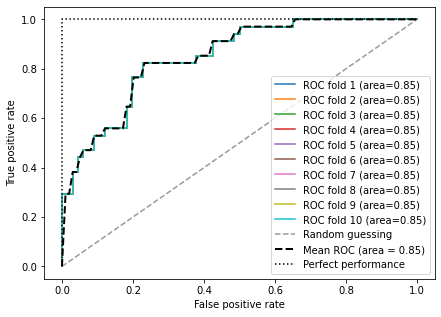

In [11]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 

cv1 = list(StratifiedKFold(n_splits=10, random_state=1, shuffle=True).split(x_train, y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv1):
    probas=clf_forest_f1.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve (y_test, probas[:, 1], pos_label=1)
    mean_tpr += np.interp (mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area=%0.2f)" %(i+1, roc_auc))
plt.plot([0, 1],[0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr/=len(cv1)
mean_tpr[-1] = 1.0
mean_auc =auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

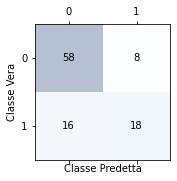

In [12]:
y_pred = clf_forest_f1.predict(x_test)
confmat = confusion_matrix(y_true=y_test,
            y_pred=y_pred)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,
    cmap=plt.cm.Blues,
    alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,
            y=i,
            s=confmat[i,j],
            va='center',
            ha='center',)
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Vera')
plt.show()

In [13]:
gs_forest_recall = GridSearchCV(estimator=pipe_forest,
                        param_grid=param_grid_forest,
                        scoring=recall,
                        n_jobs=-1,
                        refit=True,
                        cv=10,
                        verbose=10)
gs_forest_recall=gs_forest_recall.fit(x_train, y_train)
print('Migliore F1_score: ', gs_forest_recall.best_score_)
print('Parametri: ', gs_forest_recall.best_params_)
clf_forest_rec = gs_forest_recall.best_estimator_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Migliore F1_score:  0.6708791208791208
Parametri:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 50}


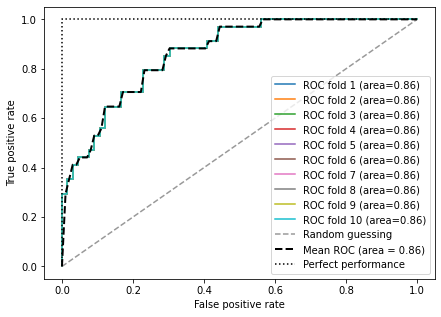

In [14]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 

cv1 = list(StratifiedKFold(n_splits=10, random_state=1, shuffle=True).split(x_train, y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv1):
    probas=clf_forest_rec.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve (y_test, probas[:, 1], pos_label=1)
    mean_tpr += np.interp (mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area=%0.2f)" %(i+1, roc_auc))
plt.plot([0, 1],[0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr/=len(cv1)
mean_tpr[-1] = 1.0
mean_auc =auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

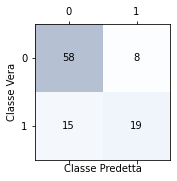

In [15]:
y_pred = clf_forest_rec.predict(x_test)
confmat = confusion_matrix(y_true=y_test,
            y_pred=y_pred)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,
    cmap=plt.cm.Blues,
    alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,
            y=i,
            s=confmat[i,j],
            va='center',
            ha='center',)
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Vera')
plt.show()

# SVM

In [20]:
degree=[3,4,5,6,7]
c_range = [0.01,1.0,10.0,100.0]
param_grid_svm = [{'svc__C': c_range,'svc__gamma': c_range,'svc__kernel': ['rbf']},
                    {'svc__C': c_range , 'svc__degree': degree , 'svc__kernel':['poly']}]

pipe_svm = make_pipeline(StandardScaler(),
                            SVC(random_state=1, probability=True))

In [21]:
gs_svm_f1 = GridSearchCV(estimator=pipe_svm,
                        param_grid=param_grid_svm,
                        scoring=F1,
                        n_jobs=-1,
                        refit=True,
                        cv=10,
                        verbose=10)
gs_svm_f1=gs_svm_f1.fit(x_train, y_train)
print('Migliore F1_score: ', gs_svm_f1.best_score_)
print('Parametri: ', gs_svm_f1.best_params_)
gs_svm_f1_best = gs_svm_f1.best_estimator_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Migliore F1_score:  0.6980808001066622
Parametri:  {'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


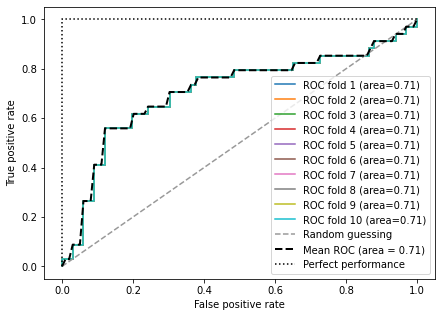

In [22]:
cv1 = list(StratifiedKFold(n_splits=10, random_state=1, shuffle=True).split(x_train, y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv1):
    probas=gs_svm_f1_best.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve (y_test, probas[:, 1], pos_label=1)
    mean_tpr += np.interp (mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area=%0.2f)" %(i+1, roc_auc))
plt.plot([0, 1],[0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr/=len(cv1)
mean_tpr[-1] = 1.0
mean_auc =auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

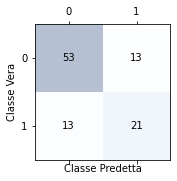

In [23]:
y_pred = gs_svm_f1_best.predict(x_test)
confmat = confusion_matrix(y_true=y_test,
            y_pred=y_pred)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,
    cmap=plt.cm.Blues,
    alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,
            y=i,
            s=confmat[i,j],
            va='center',
            ha='center',)
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Vera')
plt.show()